<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Macros/BackgroundEstimatorCRY5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and cuts definition

In [1]:
!pip install hist
!pip install mplhep
import hist

In [2]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

h5fileCRY4='drive/MyDrive/root_files_cry5/cry4df.h5'
h5fileCRY5='drive/MyDrive/root_files_cry5/cry5df.h5'

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_cry4')
from utils import Utils
util = Utils()
import math

plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import mplhep as hep
hep.style.use('ATLAS')  # or ATLAS/LHCb2

In [4]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-ba_20kvd
  Running command git clone -q https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-ba_20kvd
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5992 sha256=82420d1659e72da9f7c57dc3732ce71ac06846b86de8e78031a8cbf53ab8f15e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zgq0btpa/wheels/00/92/a8/d2a2c55928a20d8675652a7135b8880f1f4f9b655d8885d452
Successfully built mu2etools


In [5]:
TMIN = -125
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "(deent_maxr > 450)",
    "(deent_maxr < 680)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
#    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "(deent_maxr > 450)"
]
cut_lbox = " & ".join(cuts)

cut_t0='(de_t0 > 650) & (de_t0 < 1700)'
crv_time = "( crvinfo_dT < %d | crvinfo_dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_current = cut_extmom+" & "+crv_time

#Load dataframe

In [6]:
dfCRY4 = pd.read_hdf(h5fileCRY4, mode='r').query('lyield==%i & is_triggered' % 17000)
dfCRY5 = pd.read_hdf(h5fileCRY5, mode='r').query('lyield==%i' % 17000)
dfCRY4.columns = dfCRY4.columns.str.replace('__', '_')

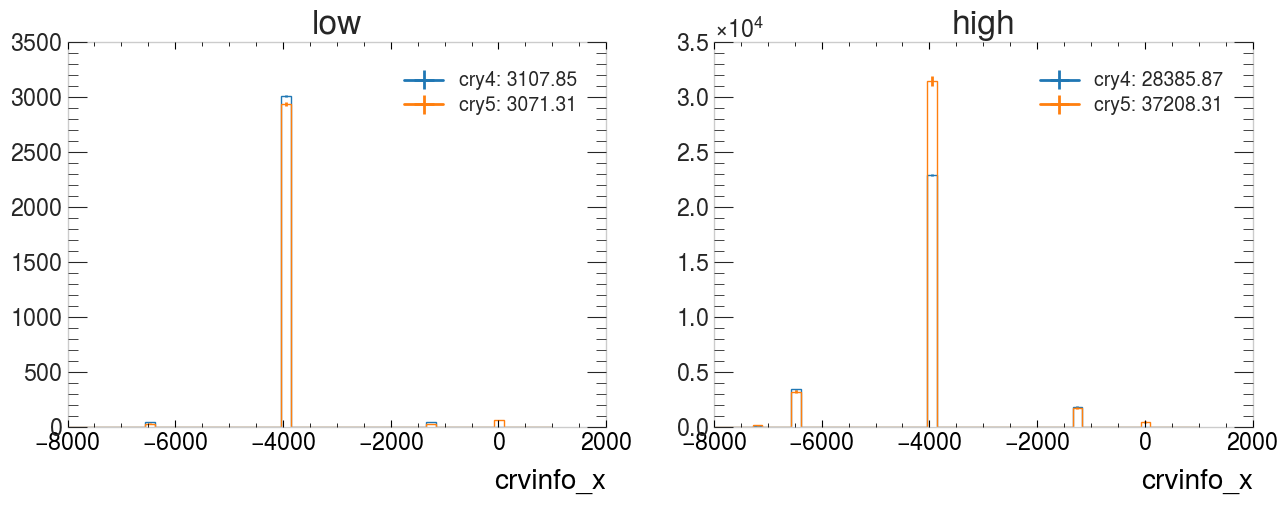

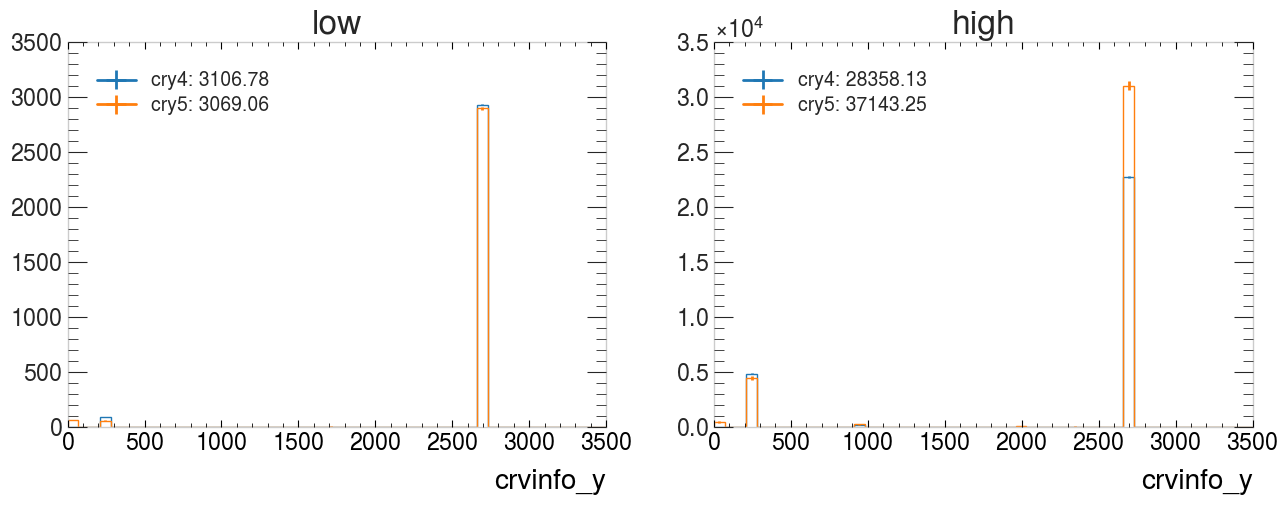

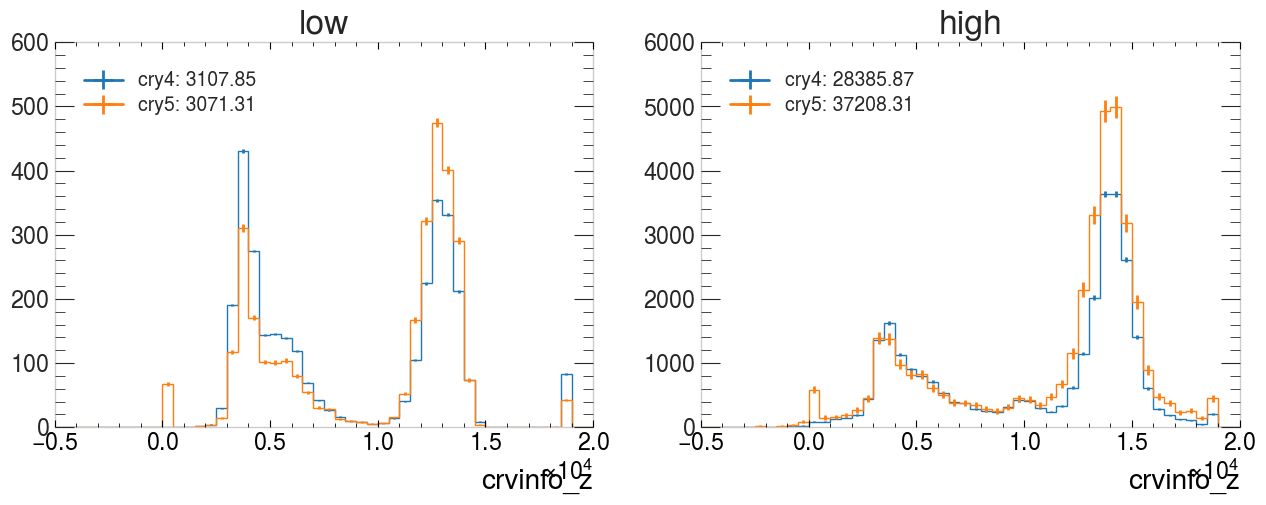

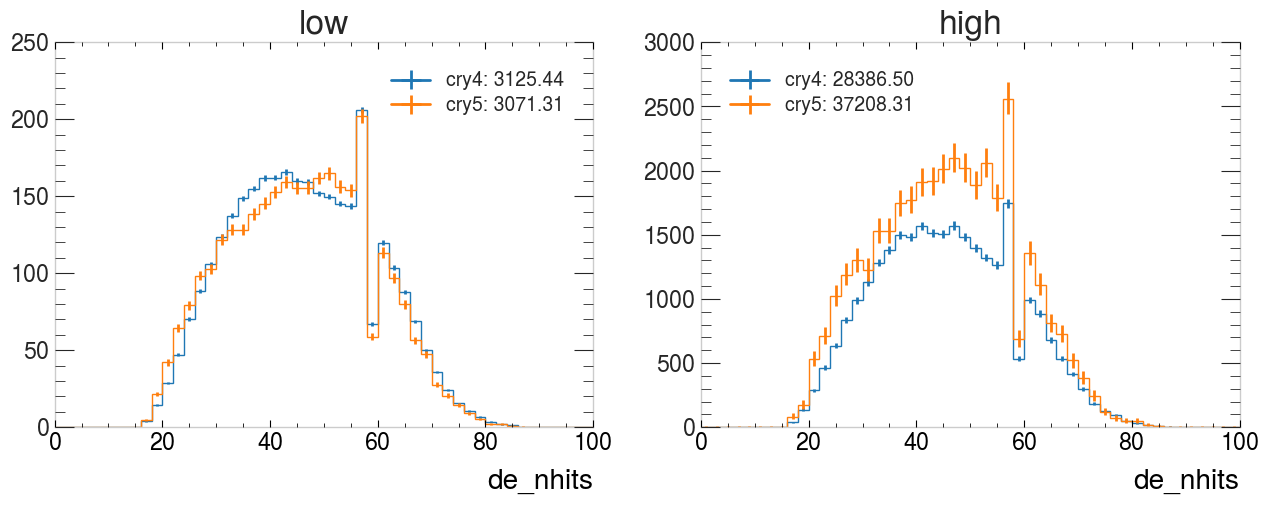

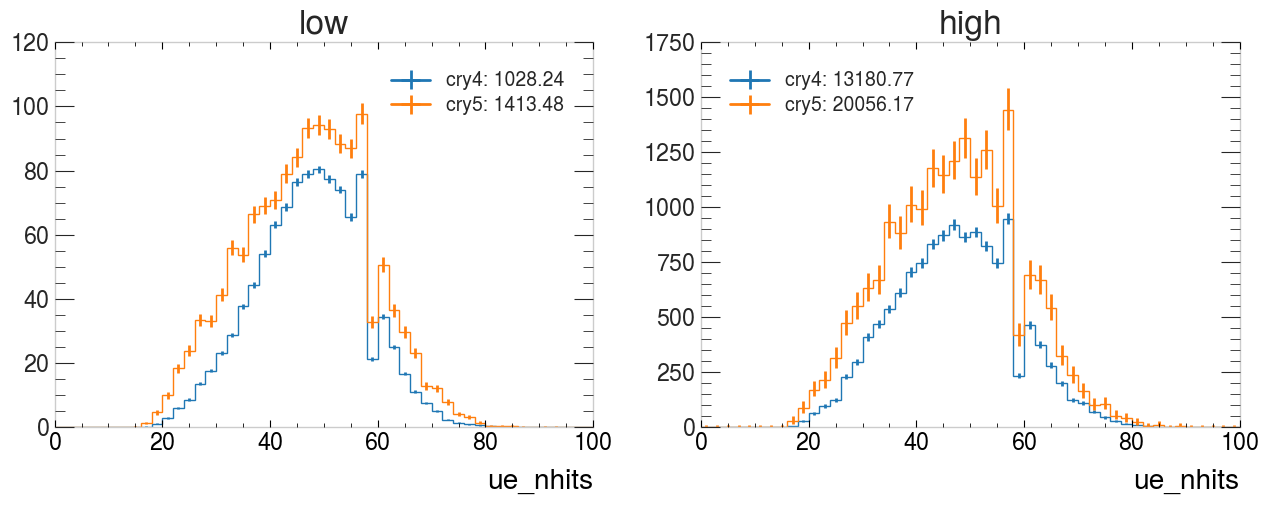

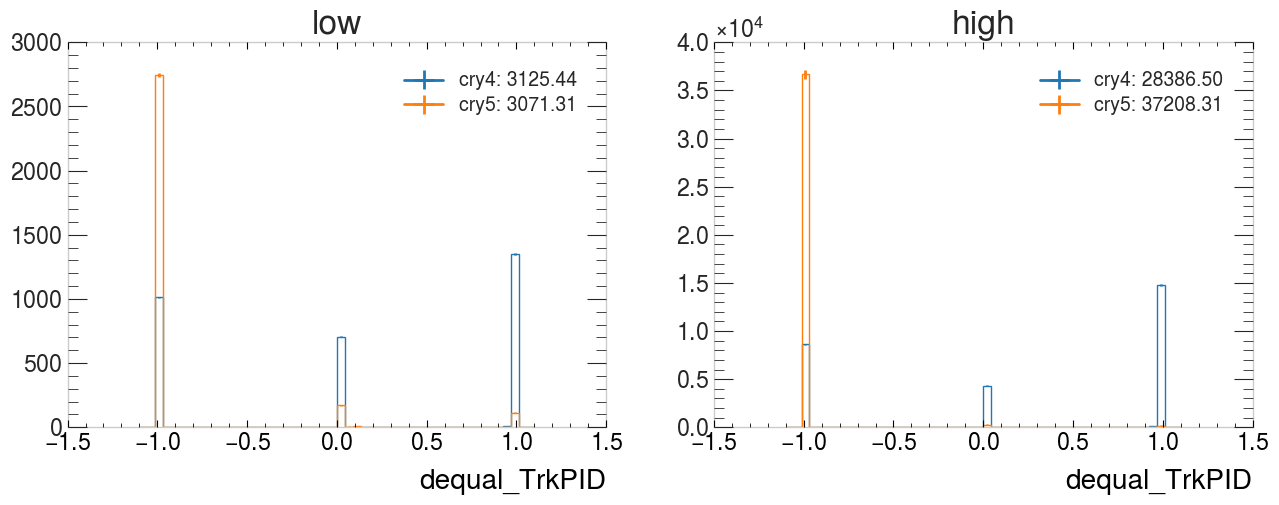

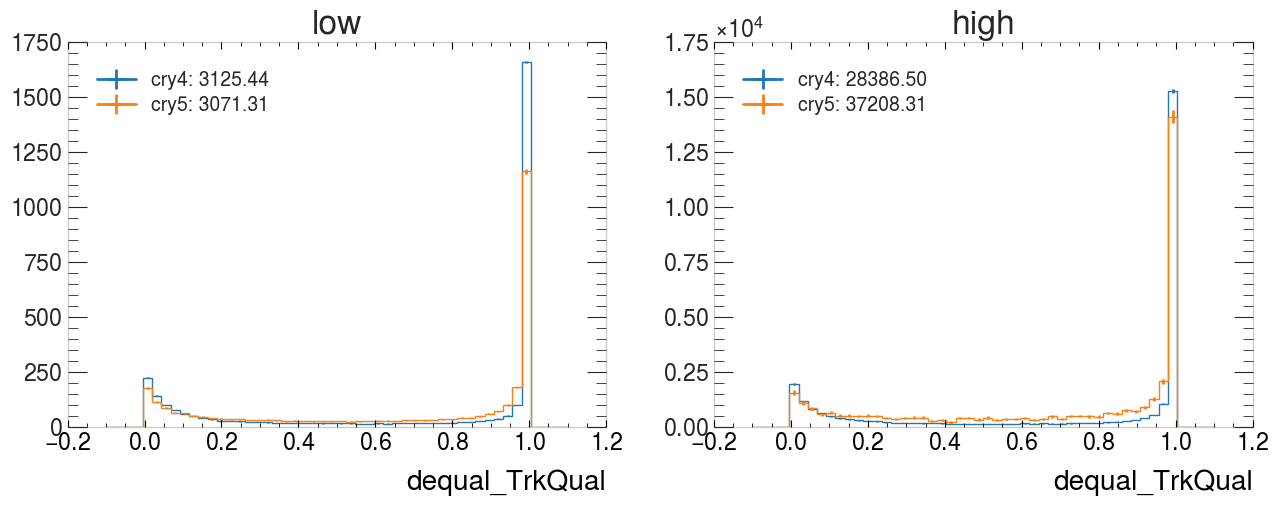

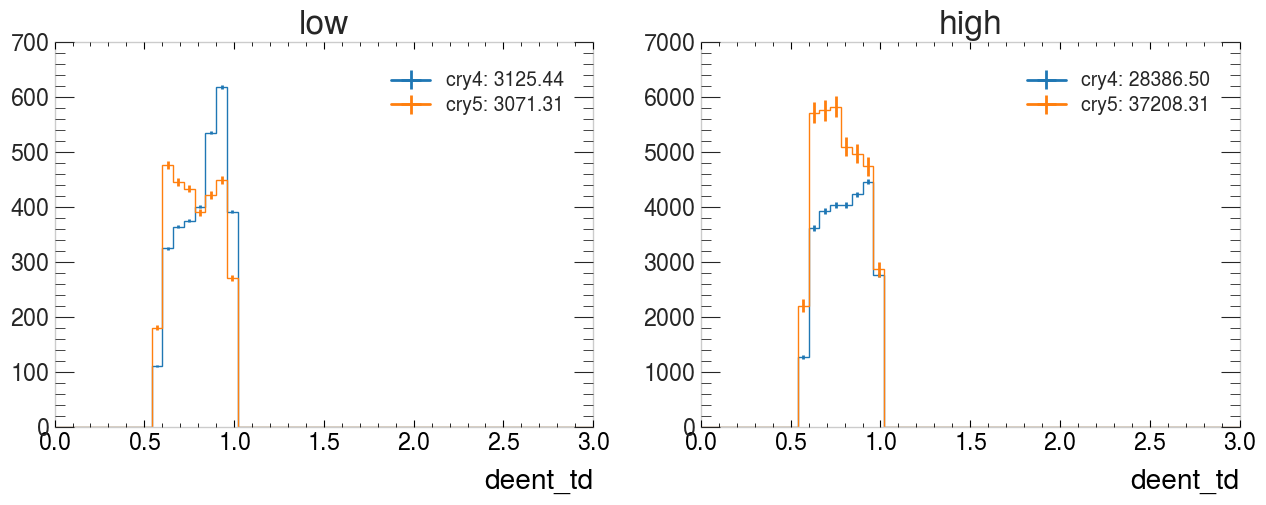

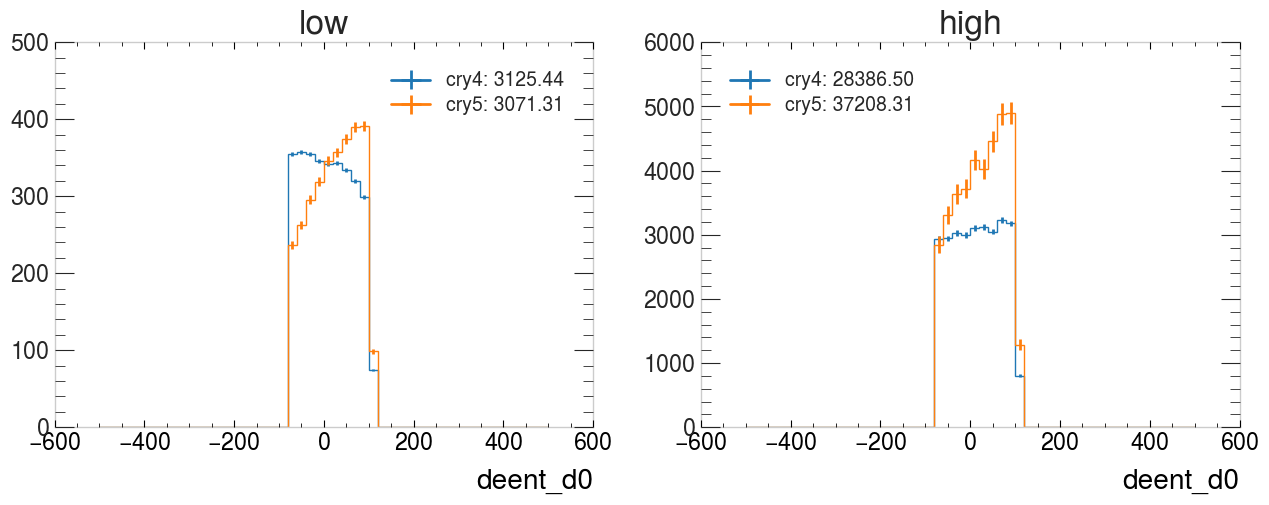

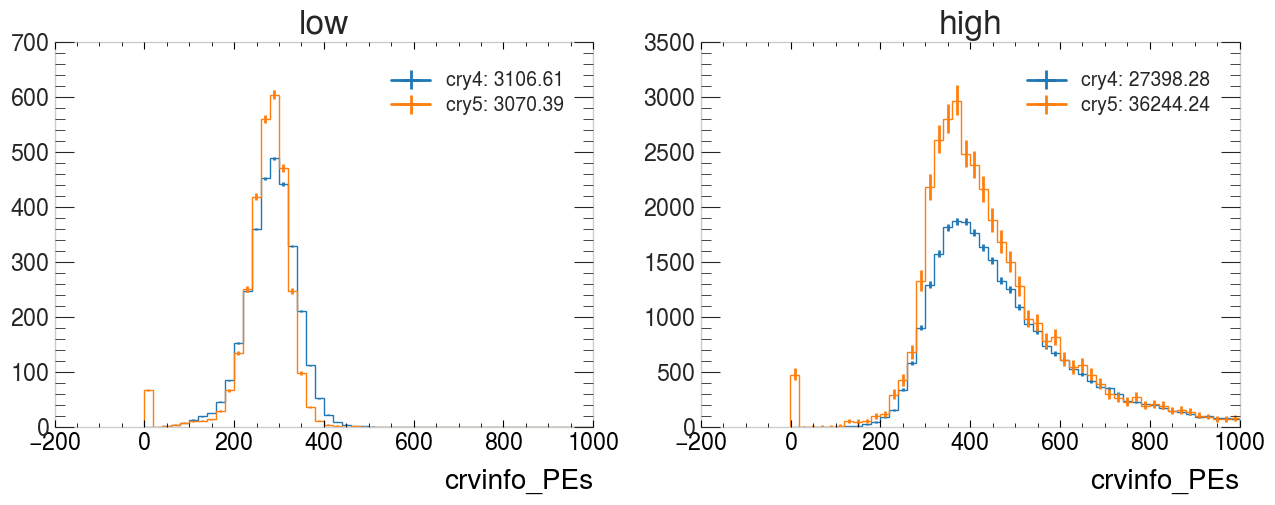

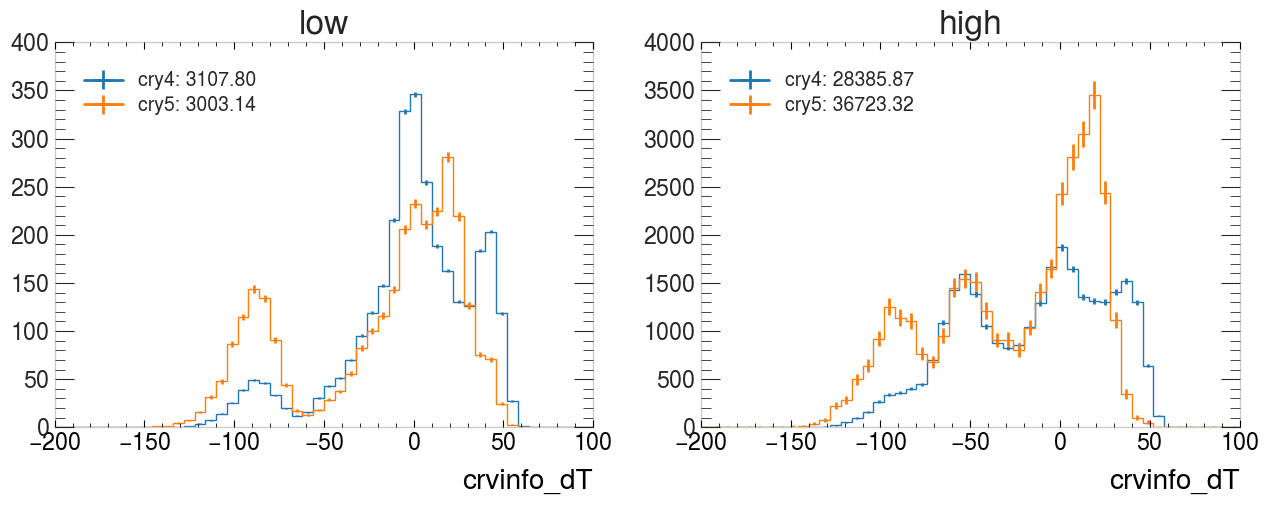

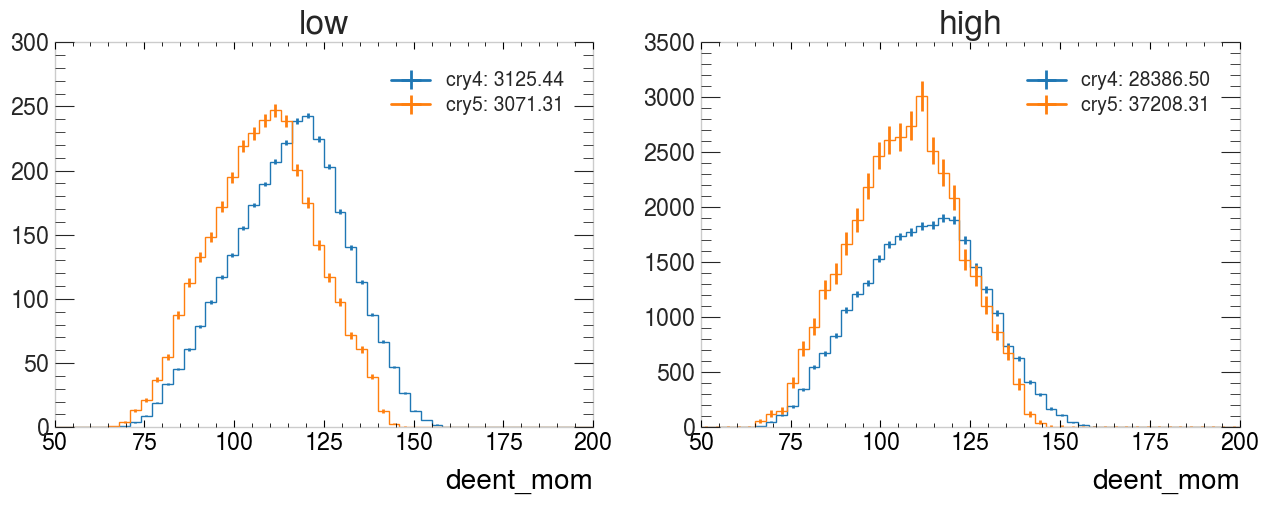

In [7]:
var_dict = utils.getVarList('allCRY5')
nLTimesCRY4 = [utils.LIVETIME_LO/utils.LIVETIME_MU2E, utils.LIVETIME_HI/utils.LIVETIME_MU2E]
nLTimesCRY5 = [utils.LIVETIME_LO_CRY5/utils.LIVETIME_MU2E, utils.LIVETIME_HI_CRY5/utils.LIVETIME_MU2E]

title=["low", "high"]

for var in var_dict.keys():
  if "deent_z0" in var or "deent_om" in var: 
    continue

  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
  h = hist.Hist(
    hist.axis.StrCategory(["cry4", "cry5"], name="cat"),
    hist.axis.Regular(50, var_dict[var][0], var_dict[var][1], name="x", label="w [units]"),
    hist.storage.Weight(),
  ) 

  cut_tmp='(deent_mom > 100) & (deent_mom < 110)'
  for i in [0,1]:
    h.reset()
    h.fill(cat="cry4", x=dfCRY4.query(cut_tbox + '& is_high==%d'%i)[var].to_numpy())
    h.fill(cat="cry5", x=dfCRY5.query(cut_tbox + '& is_high==%d'%i)[var].to_numpy())

    h_tmp=(h["cry4", :] / nLTimesCRY4[i])
    h_tmp.plot(ax=axes[i], label='cry4: %.2f'%h_tmp.counts().sum())
    h_tmp=(h["cry5", :] / nLTimesCRY5[i])
    h_tmp.plot(ax=axes[i], label='cry5: %.2f'%h_tmp.counts().sum())

    axes[i].set_xlabel(var)
    axes[i].set_title(title[i])
    axes[i].legend()


In [8]:
df = dfCRY5

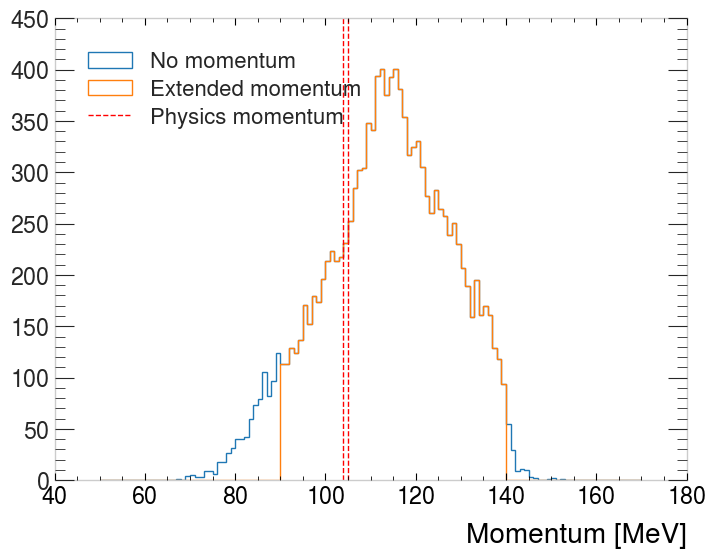

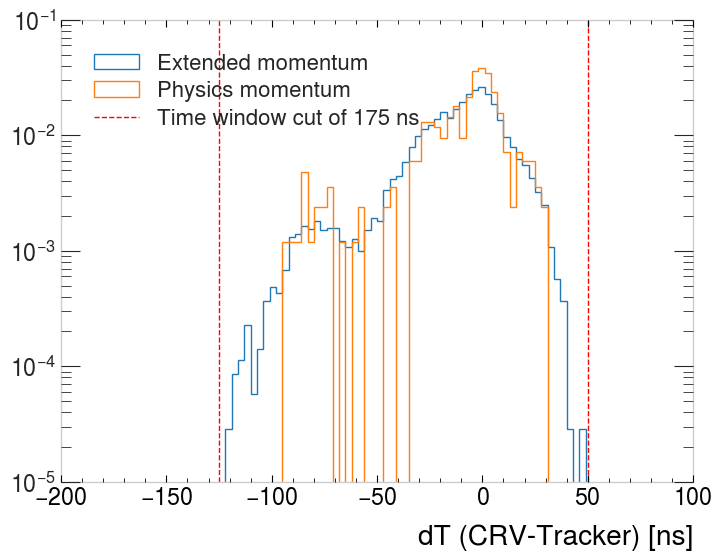

In [9]:
neve_extmom = len(df.query(cut_extmom))
neve_physmom = len(df.query(cut_phymom))
mom_scale = neve_extmom/neve_physmom
label = r'$\frac{P_{ext}}{P_{phy}} = %.1f$' % mom_scale
_, bins, _ = plt.hist(df.query(cut_nomom)['deent_mom'], bins=120, range=[50, 170], histtype='step', label='No momentum');
plt.hist(df.query(cut_extmom)['deent_mom'], bins=bins, histtype='step', label='Extended momentum');
plt.axvline(PMIN_PHY, color='r', linestyle='--', linewidth=1)
plt.axvline(PMAX_PHY, color='r', linestyle='--', label='Physics momentum', linewidth=1)
plt.legend(loc='upper left', prop={'size': 16})
plt.xlabel('Momentum [MeV]')

plt.figure()
plt.hist(df.query(cut_extmom)['crvinfo_dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Extended momentum');
plt.hist(df.query(cut_phymom)['crvinfo_dT'], bins=100, range=(-200, 100), histtype='step', density=True, label='Physics momentum');
plt.axvline(TMIN, color='r', linestyle='--', linewidth=1)
plt.axvline(TMAX, color='r', linestyle='--', linewidth=1, label='Time window cut of 175 ns')
plt.yscale('log')
plt.xlabel('dT (CRV-Tracker) [ns]');
plt.legend(loc='upper left', prop={'size': 16})

#Background estimation: production sources

In [10]:
def plot_background(cut_query, title, altitude_scale, log_scale=True, make_plot=True):

  lyield_scale=0.001726
  bg_ave = []
  pe_ave = []
  bg_err = []

  for ly in range(7000,17001,2000):
    bg = utils.getNormBackground(df, cut_query+" & lyield =="+str(ly), mom_scale, utils.LIVETIME_LO_CRY5, utils.LIVETIME_HI_CRY5)
    bg_ave.append(bg[0]*altitude_scale)
    pe_ave.append(ly*lyield_scale)
    bg_err.append(bg[1]*math.sqrt(altitude_scale))
    print("PE: %.1f, bg: %3.4f, err: %3.4f" % (ly*lyield_scale, bg[0]*altitude_scale, bg[1]))

  if make_plot:
    plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k');
    plt.title(title)
  if log_scale:
    plt.yscale('log')
  return (bg_ave, pe_ave, bg_err)

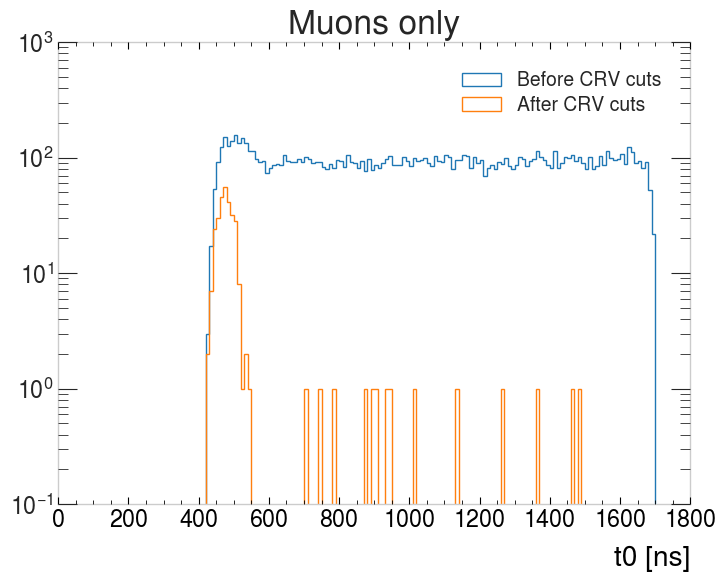

In [11]:
plt.hist(df.query(cut_extmom+" & abs(demcpri_pdg) == 13")['de_t0'], bins=170, range=(0, 1700), histtype='step', label='Before CRV cuts');
plt.hist(df.query(cut_current+" & abs(demcpri_pdg) == 13")['de_t0'], bins=170, range=(0, 1700), histtype='step', label='After CRV cuts');
plt.xlabel('t0 [ns]')
plt.title('Muons only')
plt.legend()
plt.yscale('log')

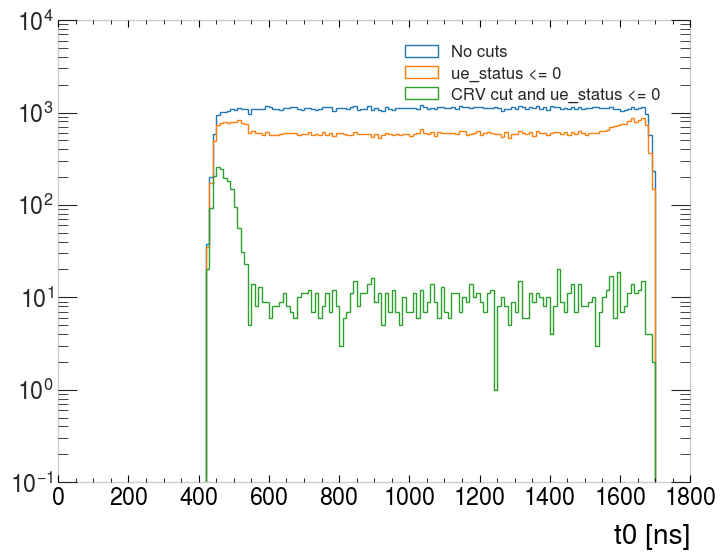

In [79]:
plt.hist(df['de_t0'], bins=170, range=(0, 1700), histtype='step', label='No cuts');
plt.hist(df.query('ue_status <= 0')['de_t0'], bins=170, range=(0, 1700), histtype='step', label='ue_status <= 0');
plt.hist(df.query('ue_status <= 0 &'+crv_time)['de_t0'], bins=170, range=(0, 1700), histtype='step', label='CRV cut and ue_status <= 0 ');
plt.xlabel('t0 [ns]')
plt.legend(prop={'size': 12});
plt.yscale('log')

In [70]:
h = hist.Hist(
  hist.axis.StrCategory(["all", "cut", "all", "cut"], name="cat"),
  hist.axis.Regular(20, 400, 1800, name="x", label="t0 [ns]"),
  hist.storage.Weight(),
) 

h.fill(cat="all", x=dfCRY5.query(cut_tbox+'& ue_status <= 0 & abs(demcpri_pdg) == 13 & is_high==0')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO)
h.fill(cat="all", x=dfCRY5.query(cut_tbox+'& ue_status <= 0 & abs(demcpri_pdg) == 13 & is_high==1')['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI)

h.fill(cat="cut", x=dfCRY5.query(cut_tbox+'& ue_status <= 0 & abs(demcpri_pdg) == 13 & is_high==0 &'+crv_time)['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_LO);
h.fill(cat="cut", x=dfCRY5.query(cut_tbox+'& ue_status <= 0 & abs(demcpri_pdg) == 13 & is_high==1 &'+crv_time)['de_t0'].to_numpy(), weight=utils.LIVETIME_MU2E/utils.LIVETIME_HI);

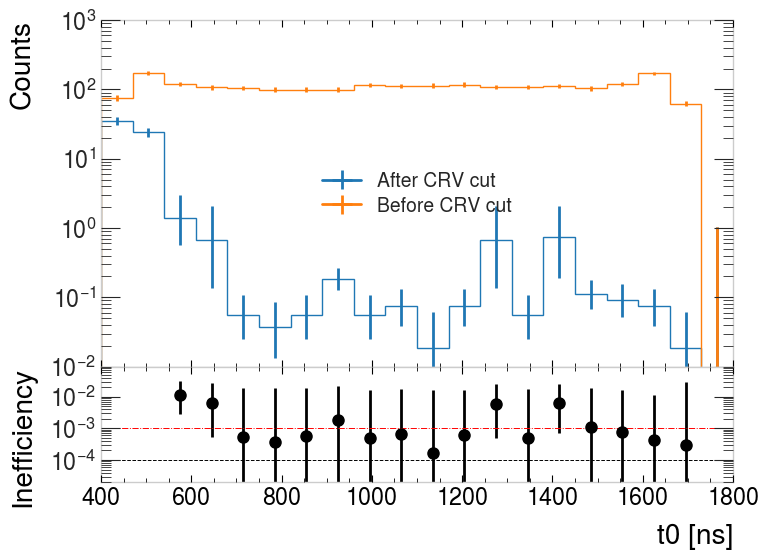

In [71]:
import matplotlib.ticker

fig = plt.figure()
h["cut", :].plot_ratio(h["all", :], rp_num_label="After CRV cut", rp_denom_label="Before CRV cut", rp_ylim=[0.00002, 0.09], rp_uncert_draw_type='line');
fig.get_axes()[1].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.get_axes()[1].set_ylabel('Inefficiency')
fig.get_axes()[1].set_yscale('log')
fig.get_axes()[0].set_yscale('log')
fig.get_axes()[1].axhline(0.0001,color='black',ls='--', linewidth=0.7)
fig.get_axes()[1].axhline(0.001,color='red',ls='-.', linewidth=0.7)

PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.0365, err: 0.0093
PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 0.1192, err: 0.0157


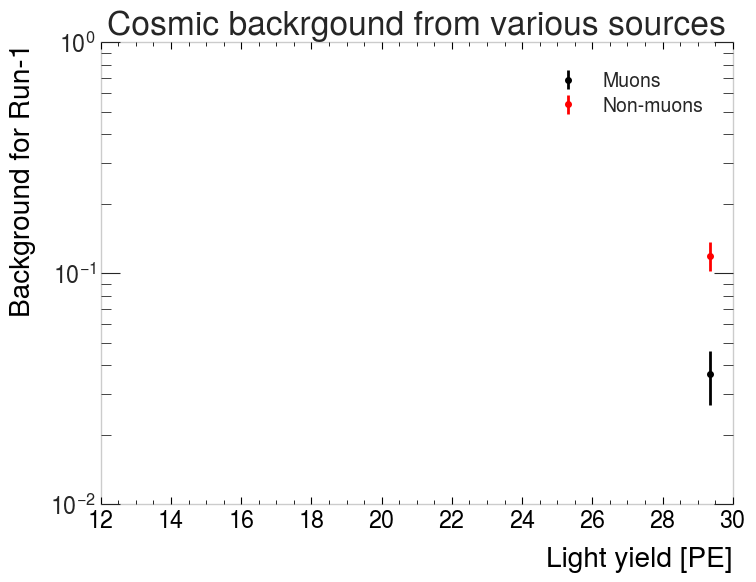

In [15]:
title='Muons'
bg_ave, pe_ave, bg_err = plot_background(cut_current+"& "+cut_t0+" & abs(demcpri_pdg) == 13", title, 1.05, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

title = 'Non-muons'
bg_ave, pe_ave, bg_err = plot_background(cut_current+"& "+cut_t0+" & abs(demcpri_pdg) != 13", title, 1.2, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.r', label=title)

plt.yscale('log');
plt.title('Cosmic backrgound from various sources');
plt.xlabel('Light yield [PE]')
plt.ylabel('Background for Run-1');
plt.legend()

In [65]:
print("Efficiency: %2.2e"%(0.0365/213.9486))

Efficiency: 1.71e-04


PE: 12.1, bg: 0.0000, err: 0.0000
PE: 15.5, bg: 0.0000, err: 0.0000
PE: 19.0, bg: 0.0000, err: 0.0000
PE: 22.4, bg: 0.0000, err: 0.0000
PE: 25.9, bg: 0.0000, err: 0.0000
PE: 29.3, bg: 213.9486, err: 5.2713


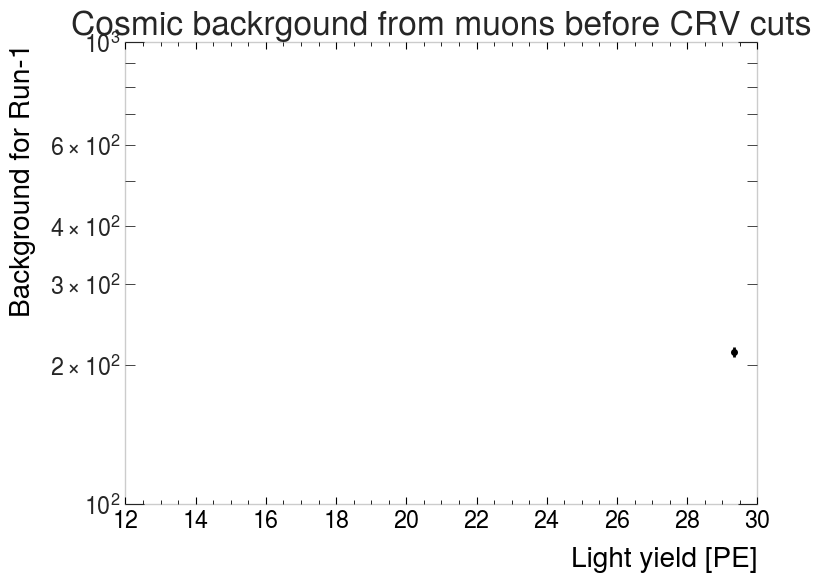

In [64]:
title='Muons'
bg_ave, pe_ave, bg_err = plot_background(cut_extmom+"& "+cut_t0+" & abs(demcpri_pdg) == 13", title, 1.0, False, False)
plt.errorbar(pe_ave, bg_ave, yerr=bg_err, fmt='.k', label=title)

plt.yscale('log');
plt.title('Cosmic backrgound from muons before CRV cuts');
plt.xlabel('Light yield [PE]')
plt.ylabel('Background for Run-1');

Text(0.5, 1.0, 'Background sources after kin and CRV cuts')

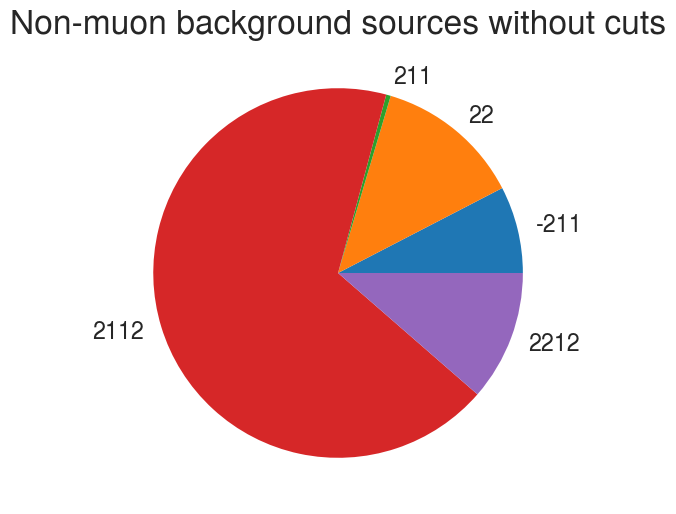

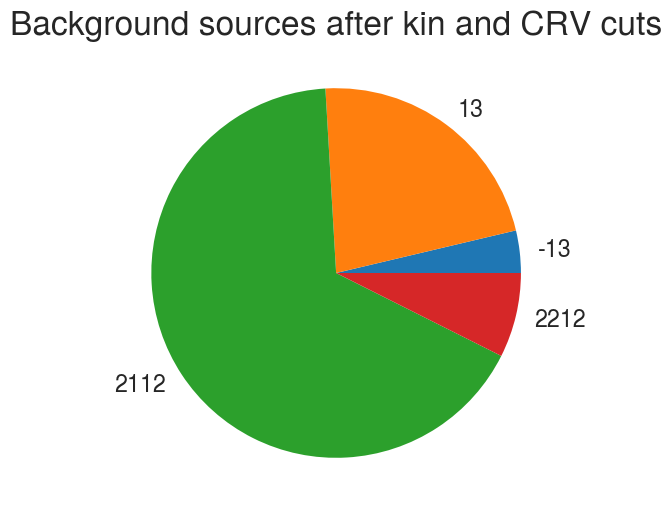

In [17]:
df.query('abs(demcpri_pdg) != 13').groupby(['demcpri_pdg']).size().plot(kind='pie', y='demcpri_pdg')
plt.ylabel('')
plt.title('Non-muon background sources without cuts')
plt.figure()
df.query(cut_current+"& "+cut_t0).groupby(['demcpri_pdg']).size().plot(kind='pie', y='demcpri_pdg', )
plt.ylabel("")
plt.title('Background sources after kin and CRV cuts')

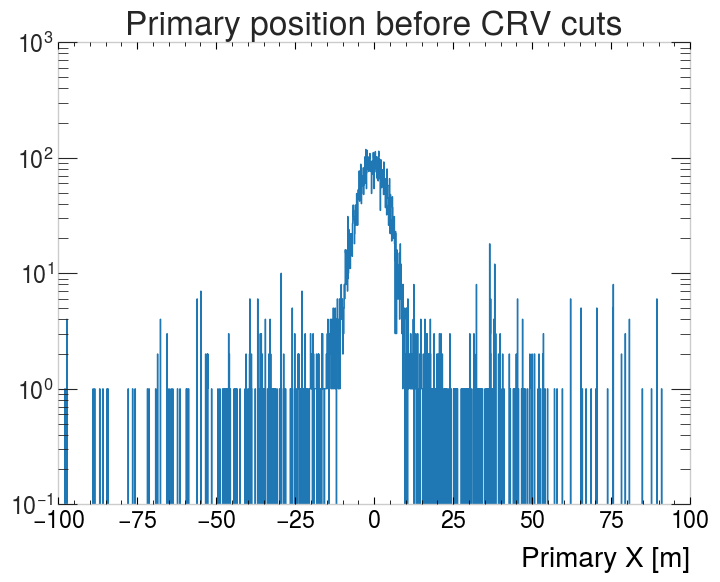

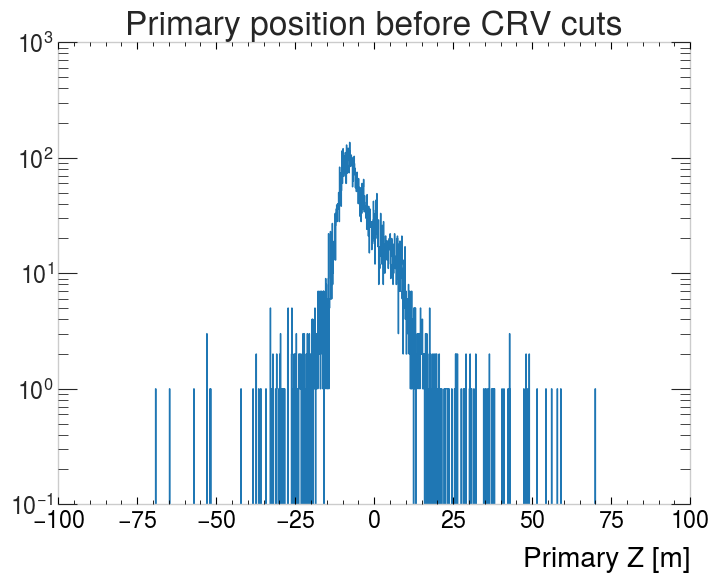

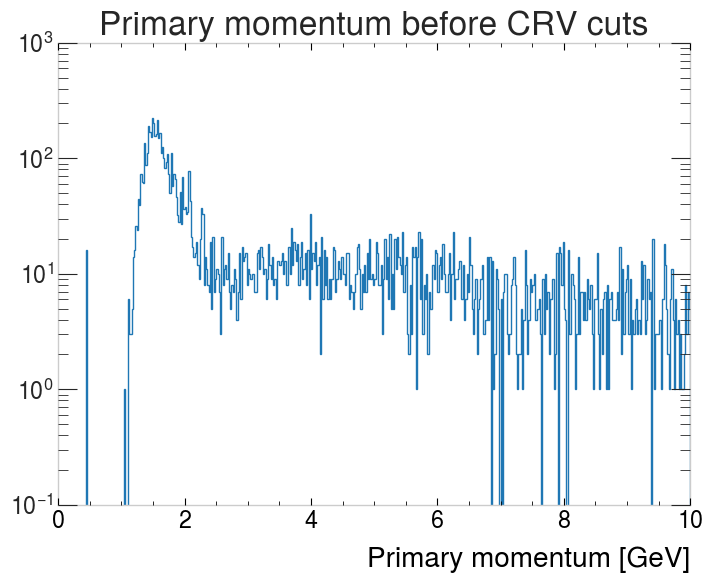

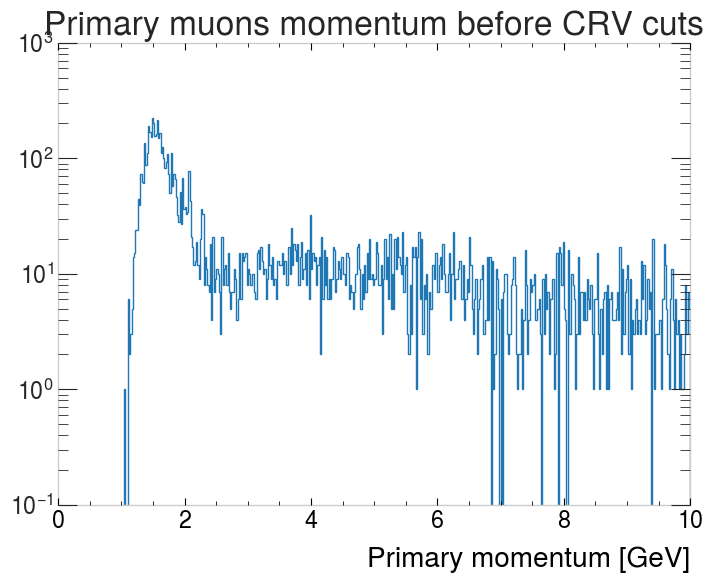

In [18]:
plt.hist(df.query(cut_extmom+"& "+cut_t0)['demcpri_posX']/1000, range=(-100, 100), bins=2000, histtype='step');
plt.yscale('log')
plt.title('Primary position before CRV cuts')
plt.xlabel('Primary X [m]')
plt.figure()
plt.hist(df.query(cut_extmom+"& "+cut_t0)['demcpri_posZ']/1000, range=(-100, 100), bins=2000, histtype='step');
plt.title('Primary position before CRV cuts')
plt.xlabel('Primary Z [m]')
plt.yscale('log')

plt.figure()
plt.hist(df.query(cut_extmom+"& "+cut_t0)['demcpri_mom']/1000, range=(0, 10), bins=500, histtype='step');
plt.title('Primary momentum before CRV cuts')
plt.xlabel('Primary momentum [GeV]')
plt.yscale('log')

plt.figure()
plt.hist(df.query(cut_extmom+"& abs(demcpri_pdg) == 13 &"+cut_t0)['demcpri_mom']/1000, range=(0, 10), bins=500, histtype='step');
plt.title('Primary muons momentum before CRV cuts')
plt.xlabel('Primary momentum [GeV]')
plt.yscale('log')

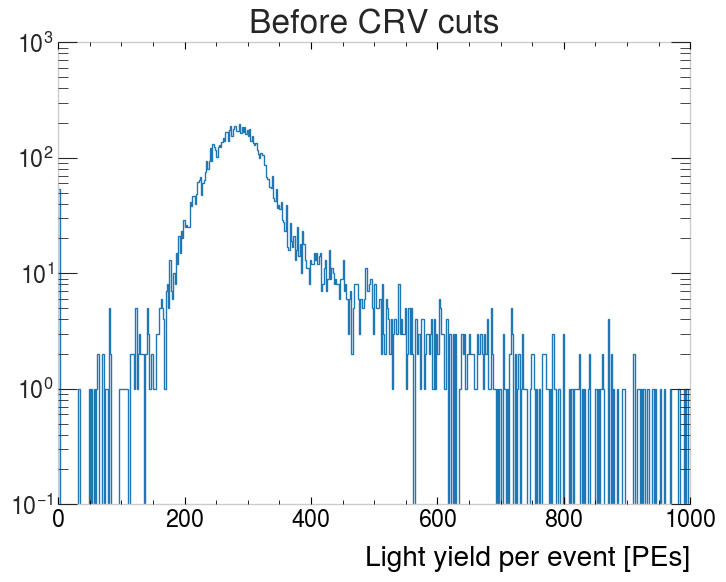

In [19]:
plt.figure()
plt.hist(df.query(cut_extmom+"& "+cut_t0)['crvinfo_PEs'], range=(0, 1000), bins=500, histtype='step');
plt.title('Before CRV cuts')
plt.xlabel('Light yield per event [PEs]')
plt.yscale('log')

In [20]:
# Rare event induced by 0.5 GeV gamma
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
df.query(cut_extmom+"& abs(demcpri_pdg) != 13 & demcpri_mom<1000 &"+cut_t0)[['demcpri_mom', 'demcpri_pdg', 'crvinfo_PEs']]

,demcpri_mom,demcpri_pdg,crvinfo_PEs
entry,,,
2421,451.248169,22,280
10241,451.248169,22,269
17312,451.248169,22,259
19353,451.248169,22,211
19913,451.248169,22,267
22358,451.248169,22,308
22360,451.248169,22,226
26382,451.248169,22,209
29564,451.248169,22,222


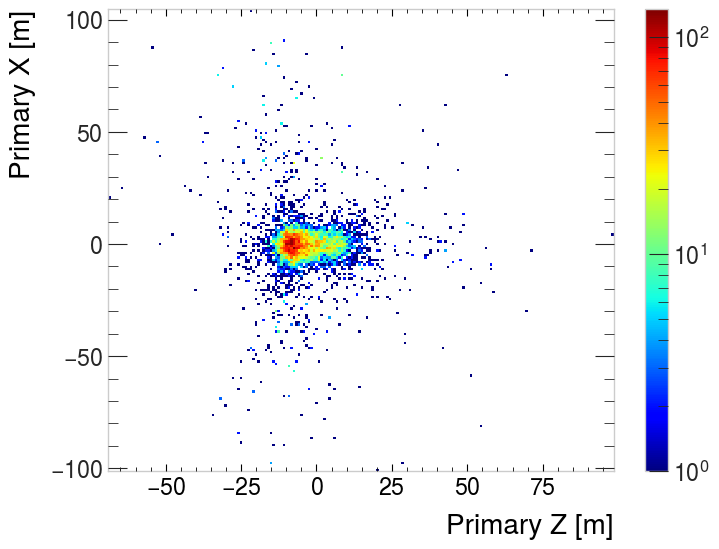

In [21]:
import matplotlib as mpl

#fig, ax = plt.subplots()
h=plt.hist2d(df.query(cut_extmom)['demcpri_posZ']/1000, df.query(cut_extmom)['demcpri_posX']/1000, bins = 200, norm=mpl.colors.LogNorm(), cmap=plt.cm.jet);
plt.colorbar(h[3])
plt.xlabel('Primary Z [m]')
plt.ylabel('Primary X [m]');